<a href="https://colab.research.google.com/github/jcandane/cxfel_work/blob/main/NLSA_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

from PIL import Image
import numpy as np
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(187)

@partial(jax.jit, static_argnums=(2,))
def diag_convolve2d(A:jax.Array, k:jax.Array, stride:int=1):
    """ 8/17/24
    Diagonal-kernel convolution with diagonal components given by k
    only sum over the diagonal-intersection, for a given stride.

    Arguments:
      A:jax.Array -- 2d-initial Array
      k:jax.Array -- 1d-diagonal-kernel (e.g. from a purely diagonal 2d-Array)
      stride:int  -- stride
    Returns:
      B:jax.Array -- 2d-diagonally convolved Array
    """
    N, M = A.shape
    s    = stride
    c    = k.size

    x           = int((N - c) // s + 1) ## result size x (hori.)
    y           = int((M - c) // s + 1) ## result size y (vert.)
    left_over   = (N-c) % s ## on the left-side
    window_size = 1 + (y-1)*s ## to stride over
    window_x = 1 + (x-1)*s ## to stride over

    left_over_y = (M-c) % s ## on the bottom-side

    end   = N - left_over
    start = end - window_size
    B     = k[0] * A[ start:end:s, start:end:s ]
    for i in range(1, c):
        start-=1
        end  -=1
        B += k[i]*A[ start:end:s, start:end:s ]
    return B

from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental import mesh_utils
from jax.experimental.shard_map import shard_map

import numpy


@jax.jit
def parallel_pair(A, B): ### 7/31/2024

    devices = mesh_utils.create_device_mesh((len(jax.devices()), 1), devices=jax.devices())
    mesh    = Mesh(devices, axis_names=('i', 'j'))

    @jax.jit
    def kernel(v_x, v_y, hps=jnp.array([])):
        return -2.*jnp.dot(v_x, v_y)

    @partial(jax.vmap, in_axes=(None, 0))
    def matrix_row(v_x, R_ix):
        return kernel(v_x, R_ix) #+ v_x + R_ix ## add v_x[None,:]

    @partial(shard_map, mesh=mesh, in_specs=(P('i'), P(None)), out_specs=P('i'))
    def batched_pairwise(A_batch, B):
        return jax.vmap(matrix_row, in_axes=(0, None))(A_batch, B)

    return batched_pairwise(A, B)

def sharded_padding(A, l):
    """
    A:jax.Array
    l:int (sharding dimension)
    GET>
    B:jax.Array (such that B.shape[0] % l = 0)
    """

    correction = (l - (A.shape[0] % l)) + A.shape[0]
    B = jnp.zeros((correction, A.shape[1]), dtype=A.dtype)
    B = B.at[:A.shape[0],:].set(A)
    return B

######==========
def jdist(A, B, Dtype=jnp.float16):

    ### move numpy.arrays (on CPU) -> jax.Arrays (on CPU)
    R  = jax.device_put(A.astype(Dtype), jax.devices("cpu")[0])
    B  = jax.device_put(B.astype(Dtype), jax.devices("cpu")[0])

    mesh_    = Mesh(numpy.array(jax.devices()).reshape((len(jax.devices()), 1)), axis_names=('i', 'j'))

    def cpu_calculation():
        return jnp.sum(R ** 2, axis=1)[:, None] + jnp.sum(B ** 2, axis=1)[None, :]

    ### shard & replicate on 4 GPUs version "_" jax.Arrays
    R_ = jax.device_put(sharded_padding(R, len(jax.devices())), NamedSharding(mesh_, P('i', 'j'))) ### pad then place for both first dimensions....
    B_ = jax.device_put(B, NamedSharding(mesh_, P(None)))

    D_ij  = cpu_calculation().block_until_ready() ### numpy is too slow, do this operation in jax
    D_ij += jax.device_put( parallel_pair(R_, B_).block_until_ready(), jax.devices("cpu")[0])[:R.shape[0],:B.shape[0]]
    return numpy.asarray(D_ij)

### test data set

In [13]:
import os
try:
    image = Image.open("dm_example.png").convert('1')
except:
    #https://github.com/jcandane/cxfel_work/blob/main/dm_example.png
    os.system("wget https://raw.githubusercontent.com/jcandane/cxfel_work/main/dm_example.png")
    image = Image.open("dm_example.png").convert('1')

### EXAMPLE sample random angles [0,180) deg
#rotated_image = image.rotate(150.2, fillcolor='#FFF')

Image.fromarray( np.array( jnp.array( ( image ) ) ) ) ### to see image need to convert into jax array


Θs   = (np.arange(1,361,1)).astype(int) #(360*np.random.rand(1200)).astype(int)
#Θs   = (np.arange(1,181,1)).astype(int) #(360*np.random.rand(1200)).astype(int)
R_ix = np.asarray( [ np.asarray( image.rotate(Θ, fillcolor='#FFF') ).reshape(-1) for Θ in Θs ] )
R_ix.shape

(360, 16129)

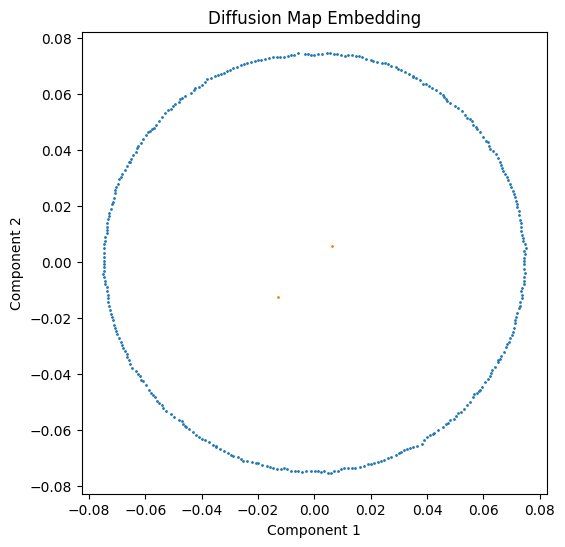

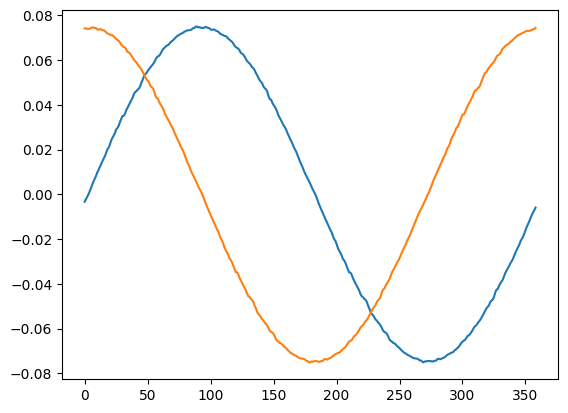

In [38]:
from scipy.sparse.linalg import eigsh, LinearOperator

##########################################
###### Parameters: R_ix, σ, k=(number of eigenvectors)
###### need to build.....iterative diagonalizer
##########################################

def DiffusionMap(R_ix, k=2, c:int=1, stride:int=1, NLSA=False):

    ### Compute the pairwise distance matrix
    D2 = jdist(R_ix, R_ix) #scipy.spatial.distance.cdist(R_ix, R_ix, 'sqeuclidean')
    D2 = diag_convolve2d(D2, jnp.ones(c), stride=stride)
    D2 = np.asarray(D2)

    ### Choose an appropriate kernel scale parameter (σ)
    σ2 = np.mean(D2)

    ##### PART of LinearOperator
    ### Construct the affinity matrix (kernel)
    P = np.exp( - D2 / (2. * σ2))

    ### Normalize the affinity matrix (Row-normalization)
    row_sums  = np.sum( P, axis=1 )
    P        @= np.diag(1.0 / row_sums)
    #####

    ### Krylov-Subspace Methods
    eigenvalues, eigenvectors = eigsh(P, k=(1+k))
    idx           = np.argsort(eigenvalues)[::-1] ## sort the eigenvalues
    eigenvalues  = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    embedding    = eigenvectors[:, 1:(1+k)]

    if not NLSA:
        return embedding
    else:
        μ          = (eigenvectors[:, 0] / eigenvalues[0])
        embedding *= μ[:,None]

        XXT = diag_convolve2d((R_ix @ R_ix.T), jnp.ones(c), stride=stride)
        def mv(v):
            return embedding.T @ (XXT @ (embedding @ v))

        A    = LinearOperator((k,k), matvec=mv)
        D, V = eigsh( A, k=embedding.shape[1]-1 )
        return V.T @ embedding.T
##########################################

embedding  = DiffusionMap(R_ix, k=3, c=2)
embeddingX = DiffusionMap(R_ix, k=3, c=2, stride=3, NLSA=True)

# Step 9: Visualize the result
plt.figure(figsize=(6, 6))
plt.scatter(embedding[:, 0], embedding[:, 1] , s=1)
plt.scatter(embeddingX[:, 0], embeddingX[:, 1] , s=1)
plt.title('Diffusion Map Embedding')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

plt.plot(np.arange(len(embedding[:, 0])), embedding[:, 0])
plt.plot(np.arange(len(embedding[:, 1])), embedding[:, 1])
plt.show()